## Coverage-efficiency plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:00<00:00, 30.64it/s]


[1.0, 0.9543037414550781, 0.9532956480979919, 0.9595566391944885, 0.9602517485618591, 0.9669100046157837, 0.9653859734535217, 0.9675214290618896, 0.9716317653656006, 0.9765530228614807, 0.9759202003479004, 0.9799495339393616, 0.9821020364761353, 0.9826576709747314, 0.9874501824378967, 0.9872519373893738, 0.9895608425140381, 0.9946627020835876, 0.9954936504364014, 0.9990330934524536]


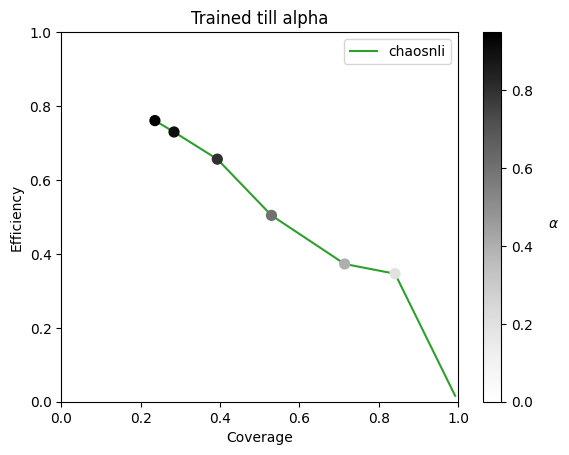

In [5]:
%load_ext autoreload
%autoreload 2
from models import LikelihoodEnsemble, get_model
import torch
from data import get_data_task
import utils
from probly.metrics import coverage, efficiency
import matplotlib.pyplot as plt
PATH = '/home/scratch/likelihood-ensembles/checkpoints'

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
dataset = 'chaosnli'
base = 'fcnet'
seed = 4
tobias = 100
n_members = 20
classes = 3
covs = []
effs = []
test_loader = get_data_task(dataset, seed=seed)
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95]
for i, alpha in enumerate(alphas):
    ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
    utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
    ensemble = ensemble.to(device)
    ensemble.eval()
    outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    cov = coverage(outputs, targets)
    eff = efficiency(outputs)
    covs.append(cov)
    effs.append(eff)

print(ensemble.rls)
plt.plot(covs, effs,color='#2ca02c', label=dataset)
plt.scatter(covs, effs, cmap='Greys', c=alphas, marker='o', s=50, zorder=10)
plt.xlabel('Coverage')
plt.ylabel('Efficiency')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend()
plt.title('Trained till alpha')
cb = plt.colorbar(orientation='vertical')
cb.set_label('$\\alpha$', rotation=0, labelpad=15,weight='bold')
# plt.savefig('plots/pareto_chaosnli_till_alpha.pdf', transparent=True)

## Coverage-efficiency plot with baselines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:00<00:00, 27.10it/s]


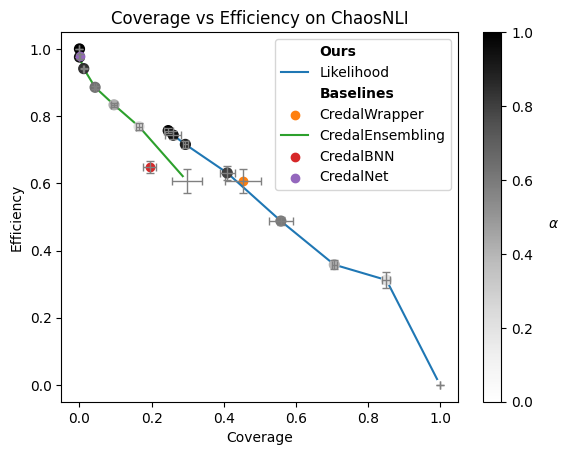

In [6]:
%load_ext autoreload
%autoreload 2
from models import LikelihoodEnsemble, get_model, Ensemble, DesterckeEnsemble, CaprioEnsemble, WangEnsemble
import torch
import numpy as np
from data import get_data_task
import utils
from probly.metrics import coverage, efficiency, coverage_convex_hull
import matplotlib.pyplot as plt
import pickle
PATH = '/home/scratch/likelihood-ensembles/checkpoints'

data_dict = {'chaosnli': 'ChaosNLI', 'cifar10': 'CIFAR10', 'qualitymri': 'QualityMRI'}
color_dict = {'ours': '#2ca02c', 'credalwrapper': '#2ca02c', 'credalensembling': '#2ca02c', 'credalbnn': '#2ca02c'}
results_dict = {'ours': {}, 'credalwrapper': {}, 'credalensembling': {}, 'credalbnn': {}, 'credalnet': {}}

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
dataset = 'chaosnli'
base = 'fcnet'
seeds = [4,5,6]
tobias = 100
n_members = 20
classes = 3
methods = ['ours', 'credalwrapper', 'credalensembling', 'credalbnn', 'credalnet']
plt.plot()
cmap = plt.get_cmap('tab10')
n = 10
colors = [cmap(i / (n - 1)) for i in range(n)]
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]

# OURS
covs = np.empty((len(seeds), len(alphas)))
effs = np.empty((len(seeds), len(alphas)))
for j, seed in enumerate(seeds):
    test_loader = get_data_task(dataset, seed=seed)
    for i, alpha in enumerate(alphas):
        ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
        utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
        ensemble = ensemble.to(device)
        ensemble.eval()
        outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
        outputs = outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        cov = coverage(outputs, targets)
        eff = efficiency(outputs)
        covs[j, i] = cov
        effs[j, i] = eff
results_dict['ours']['cov'] = covs.mean(0)
results_dict['ours']['eff'] = effs.mean(0)
results_dict['ours']['cov_std'] = covs.std(0)
results_dict['ours']['eff_std'] = effs.std(0)
plt.plot([], [], label='Ours', color='#ffffff')
plt.plot([0], [1], color=colors[0])
plt.plot(covs.mean(0), effs.mean(0), label='Likelihood', color=colors[0])
plt.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=50, zorder=10, vmin=0, vmax=1)

for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
    plt.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=15)


cb = plt.colorbar(orientation='vertical')
cb.set_label('$\\alpha$', rotation=0, labelpad=15,weight='bold')

# CREDALWRAPPER
covs = np.empty((len(seeds)))
effs = np.empty((len(seeds)))
for j, seed in enumerate(seeds):
    test_loader = get_data_task(dataset, seed=seed)
    ensemble = Ensemble(get_model(base, classes), n_members)
    ensemble.load_state_dict(torch.load(f'{PATH}/baseline_{dataset}_credalwrapper_{n_members}_{seed}'))
    ensemble = ensemble.to(device)
    ensemble.eval()
    outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    cov = coverage(outputs, targets)
    eff = efficiency(outputs)
    covs[j] = cov
    effs[j] = eff
results_dict['credalwrapper']['cov'] = covs.mean()
results_dict['credalwrapper']['eff'] = effs.mean()
results_dict['credalwrapper']['cov_std'] = covs.std()
results_dict['credalwrapper']['eff_std'] = effs.std()
plt.plot([], [], label='Baselines', color='#ffffff')
plt.scatter(covs.mean(), effs.mean(), label='CredalWrapper', color=colors[1])
plt.errorbar(covs.mean(0), effs.mean(0), xerr=covs.std(0), yerr=effs.std(0), fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=5)

# CREDALENSEMBLING
covs = np.empty((len(seeds), len(alphas)-1))
effs = np.empty((len(seeds), len(alphas)-1))
for j, seed in enumerate(seeds):
    test_loader = get_data_task(dataset, seed=seed)
    ensemble = DesterckeEnsemble(get_model(base, classes), n_members)
    ensemble.load_state_dict(torch.load(f'{PATH}/baseline_{dataset}_credalensembling_{n_members}_{seed}'))
    ensemble = ensemble.to(device)
    ensemble.eval()
    for i, alpha in enumerate(alphas[:-1]):
        outputs, targets = utils.torch_get_outputs_destercke(ensemble, test_loader, device, alpha)
        outputs = outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        cov = coverage_convex_hull(outputs, targets)
        eff = efficiency(outputs)
        covs[j, i] = cov
        effs[j, i] = eff
results_dict['credalensembling']['cov'] = covs.mean(0)
results_dict['credalensembling']['eff'] = effs.mean(0)
results_dict['credalensembling']['cov_std'] = covs.std(0)
results_dict['credalensembling']['eff_std'] = effs.std(0)
plt.plot(covs.mean(0), effs.mean(0), label='CredalEnsembling', color=colors[2])
plt.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas[:-1], marker='o', s=50, zorder=10)

for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
    plt.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=15)

# CREDALBNN
covs = np.empty((len(seeds)))
effs = np.empty((len(seeds)))
for j, seed in enumerate(seeds):
    test_loader = get_data_task(dataset, seed=seed)
    ensemble = CaprioEnsemble(get_model(base, classes), n_members, [0,1], [0,1])
    ensemble.load_state_dict(torch.load(f'{PATH}/baseline_{dataset}_credalbnn_{n_members}_{seed}'))
    ensemble = ensemble.to(device)
    ensemble.eval()
    outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    cov = coverage_convex_hull(outputs, targets)
    eff = efficiency(outputs)
    covs[j] = cov
    effs[j] = eff

results_dict['credalbnn']['cov'] = covs.mean()
results_dict['credalbnn']['eff'] = effs.mean()
results_dict['credalbnn']['cov_std'] = covs.std()
results_dict['credalbnn']['eff_std'] = effs.std()
plt.scatter(covs.mean(), effs.mean(), label='CredalBNN', color=colors[3])
plt.errorbar(covs.mean(0), effs.mean(0), xerr=covs.std(0), yerr=effs.std(0), fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=5)

# CREDALNET
covs = np.empty((len(seeds)))
effs = np.empty((len(seeds)))
base = 'cre' + base
for j, seed in enumerate(seeds):
    test_loader = get_data_task(dataset, seed=seed)
    ensemble = WangEnsemble(get_model(base, classes), n_members, 0, classes)
    ensemble.load_state_dict(torch.load(f'{PATH}/baseline_{dataset}_credalnet_{n_members}_{seed}'))
    ensemble = ensemble.to(device)
    ensemble.eval()
    outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    cov = coverage(outputs, targets)
    eff = efficiency(outputs)
    covs[j] = cov
    effs[j] = eff

results_dict['credalnet']['cov'] = covs.mean()
results_dict['credalnet']['eff'] = effs.mean()
results_dict['credalnet']['cov_std'] = covs.std()
results_dict['credalnet']['eff_std'] = effs.std()

with open(f'figures/{dataset}_result.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

plt.scatter(covs.mean(), effs.mean(), label='CredalNet', color=colors[4], zorder=25)
plt.errorbar(covs.mean(0), effs.mean(0), xerr=covs.std(0), yerr=effs.std(0), fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

legend = plt.legend()
legend.get_texts()[0].set_fontweight('bold')
legend.get_texts()[2].set_fontweight('bold')
plt.xlabel('Coverage')
plt.ylabel('Efficiency')
plt.title(f'Coverage vs Efficiency on {data_dict[dataset]}')
plt.show()
#plt.savefig(f'figures/cov_eff_{dataset}.pdf',bbox_inches='tight')

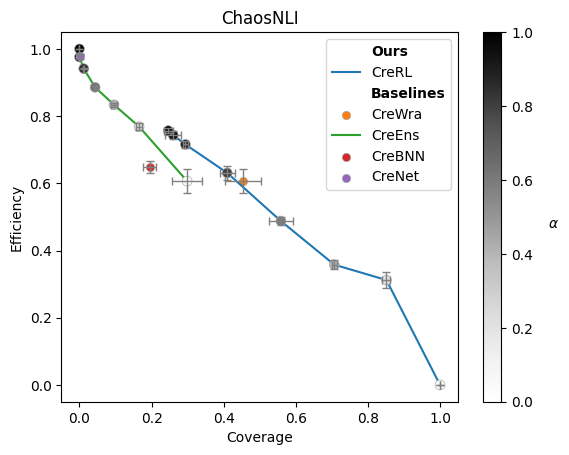

In [7]:
dataset = 'chaosnli'
with open(f'figures/{dataset}_result.pkl', 'rb') as f:
    results_dict = pickle.load(f)

edgecolor = 'darkgrey'
plt.plot([], [], label='Ours', color='#ffffff')
plt.plot([0], [1], color=colors[0])
plt.plot(results_dict['ours']['cov'], results_dict['ours']['eff'], label='CreRL', color=colors[0])
plt.scatter(results_dict['ours']['cov'], results_dict['ours']['eff'], cmap='Greys', c=alphas, marker='o', s=50, zorder=10, vmin=0, vmax=1, edgecolors=edgecolor, linewidths=0.5)

for x, y, xe, ye in zip(results_dict['ours']['cov'], results_dict['ours']['eff'], results_dict['ours']['cov_std'], results_dict['ours']['eff_std']):
    plt.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=15)


cb = plt.colorbar(orientation='vertical')
cb.set_label('$\\alpha$', rotation=0, labelpad=15,weight='bold')

#CREDALWRAPPER
plt.plot([], [], label='Baselines', color='#ffffff')
plt.scatter(results_dict['credalwrapper']['cov'], results_dict['credalwrapper']['eff'], label='CreWra', color=colors[1], edgecolors=edgecolor, linewidths=0.5)
plt.errorbar(results_dict['credalwrapper']['cov'], results_dict['credalwrapper']['eff'], xerr=results_dict['credalwrapper']['cov_std'], yerr=results_dict['credalwrapper']['eff_std'], fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=5)

#CREDALENSEMBLING
plt.plot(results_dict['credalensembling']['cov'], results_dict['credalensembling']['eff'], label='CreEns', color=colors[2])
plt.scatter(results_dict['credalensembling']['cov'], results_dict['credalensembling']['eff'], cmap='Greys', c=alphas[:-1], marker='o', s=50, zorder=10, edgecolors=edgecolor, linewidths=0.5)
for x, y, xe, ye in zip(results_dict['credalensembling']['cov'], results_dict['credalensembling']['eff'], results_dict['credalensembling']['cov_std'], results_dict['credalensembling']['eff_std']):
    plt.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=15)

#CREDALBNN
plt.scatter(results_dict['credalbnn']['cov'], results_dict['credalbnn']['eff'], label='CreBNN', color=colors[3], edgecolors=edgecolor, linewidths=0.5)
plt.errorbar(results_dict['credalbnn']['cov'], results_dict['credalbnn']['eff'], xerr=results_dict['credalbnn']['cov_std'], yerr=results_dict['credalbnn']['eff_std'], fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=5)

#CREDALNET
plt.scatter(results_dict['credalnet']['cov'], results_dict['credalnet']['eff'], label='CreNet', color=colors[4], zorder=25, edgecolors=edgecolor, linewidths=0.5)
plt.errorbar(results_dict['credalnet']['cov'], results_dict['credalnet']['eff'], xerr=results_dict['credalnet']['cov_std'], yerr=results_dict['credalnet']['eff_std'], fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

legend = plt.legend()
legend.get_texts()[0].set_fontweight('bold')
legend.get_texts()[2].set_fontweight('bold')
plt.xlabel('Coverage')
plt.ylabel('Efficiency')
plt.title(f'{data_dict[dataset]}')
plt.show()
#plt.savefig('figures/cov_eff_chaosnli.pdf',bbox_inches='tight')

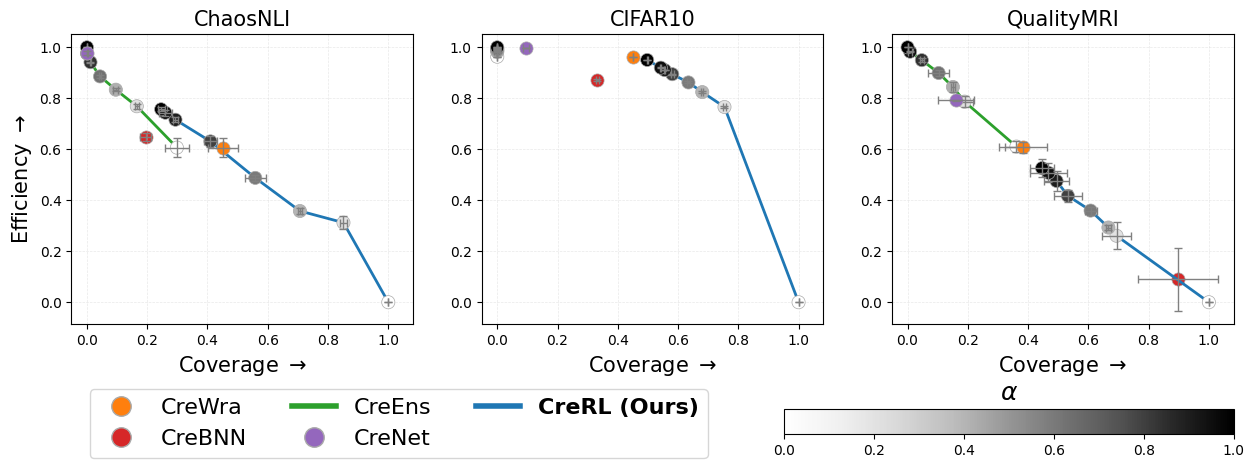

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

datasets = ['chaosnli', 'cifar10', 'qualitymri']
data_dict = {'chaosnli': 'ChaosNLI', 'cifar10': 'CIFAR10', 'qualitymri': 'QualityMRI'}

cmap = plt.get_cmap('tab10')
n = 10
colors = [cmap(i / (n - 1)) for i in range(n)]
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
edgecolor = 'darkgrey'
s=90
line_width=2
font_size=15

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# To collect alpha values for scatter color mapping
all_alphas = []

for i, dataset in enumerate(datasets):
    with open(f'figures/{dataset}_result.pkl', 'rb') as f:
        results_dict = pickle.load(f)

    ax = axes[i]
    ax.tick_params(axis='y', which='both', labelleft=True)
    ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.plot([], [], label='Ours', color='#ffffff')
    # Plot CreRL
    p1 = ax.plot(results_dict['ours']['cov'], results_dict['ours']['eff'], label='CreRL', color=colors[0], linewidth=line_width)
    sc1 = ax.scatter(results_dict['ours']['cov'], results_dict['ours']['eff'], c=alphas, cmap='Greys',
                     marker='o', s=s, zorder=10, vmin=0, vmax=1,
                     edgecolors=edgecolor, linewidths=0.5)
    for x, y, xe, ye in zip(results_dict['ours']['cov'], results_dict['ours']['eff'],
                            results_dict['ours']['cov_std'], results_dict['ours']['eff_std']):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=15)


    ax.plot([], [], label='Baselines', color='#ffffff')
    # Plot CreEns
    p2 = ax.plot(results_dict['credalensembling']['cov'], results_dict['credalensembling']['eff'], label='CreEns', color=colors[2], linewidth=line_width)
    sc2 = ax.scatter(results_dict['credalensembling']['cov'], results_dict['credalensembling']['eff'], cmap='Greys', c=alphas[:-1], marker='o', s=s, zorder=10, edgecolors=edgecolor, linewidths=0.5)
    for x, y, xe, ye in zip(results_dict['credalensembling']['cov'], results_dict['credalensembling']['eff'], results_dict['credalensembling']['cov_std'], results_dict['credalensembling']['eff_std']):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=15)

    # Plot CreWra
    sc3 = ax.scatter(results_dict['credalwrapper']['cov'], results_dict['credalwrapper']['eff'],
                     label='CreWra', color=colors[1], edgecolors=edgecolor, linewidths=0.5, s=s, zorder=16)
    ax.errorbar(results_dict['credalwrapper']['cov'], results_dict['credalwrapper']['eff'],
                xerr=results_dict['credalwrapper']['cov_std'],
                yerr=results_dict['credalwrapper']['eff_std'],
                fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

    # Plot CreNet
    ax.scatter(results_dict['credalnet']['cov'], results_dict['credalnet']['eff'], label='CreNet', color=colors[4], zorder=25, edgecolors=edgecolor, linewidths=0.5, s=s)
    ax.errorbar(results_dict['credalnet']['cov'], results_dict['credalnet']['eff'], xerr=results_dict['credalnet']['cov_std'], yerr=results_dict['credalnet']['eff_std'], fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)


    # Plot CreBNN
    ax.scatter(results_dict['credalbnn']['cov'], results_dict['credalbnn']['eff'], label='CreBNN', color=colors[3], edgecolors=edgecolor, linewidths=0.5, s=s)
    ax.errorbar(results_dict['credalbnn']['cov'], results_dict['credalbnn']['eff'], xerr=results_dict['credalbnn']['cov_std'], yerr=results_dict['credalbnn']['eff_std'], fmt='none', ecolor='grey', elinewidth=1, capsize=3, zorder=5)

    ax.set_title(data_dict[dataset], fontsize=font_size)
    if i == 0:
        ax.set_ylabel('Efficiency '+  r"$\rightarrow$", fontsize=font_size)
    ax.set_xlabel('Coverage ' + r"$\rightarrow$", fontsize=font_size)

# Custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1],
           markeredgecolor=edgecolor, markersize=14, label='CreWra'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[3],
           markeredgecolor=edgecolor, markersize=14, label='CreBNN'),
    Line2D([0], [0], color=colors[2], lw=4, label='CreEns'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[4],
           markeredgecolor=edgecolor, markersize=14, label='CreNet'),
    Line2D([0], [0], color=colors[0], lw=4, label='CreRL (Ours)')
]

# Add global legend below all plots
legend = fig.legend(handles=legend_elements, loc='lower left', ncol=3, frameon=True,
           bbox_to_anchor=(0.13, 0.01), fontsize=font_size+1)
legend_texts = legend.get_texts()
legend_texts[-1].set_fontweight('bold')  # 0 = first label (CreRL)

# Create inset axis below the last subplot
cbar_ax = inset_axes(axes[-1], width="30%", height="5%", loc='lower center',
                     bbox_to_anchor=(0.25, 0.08, 1.0, 1.0),
                     bbox_transform=fig.transFigure, borderpad=0)

cb = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')
cb.set_label(r'$\alpha$', weight='bold', fontsize=font_size+3, labelpad=7)
cb.ax.xaxis.set_label_position('top')

plt.subplots_adjust(bottom=0.3) # Leave space for colorbar
#plt.savefig('figures/cov_eff_all_datasets.svg', bbox_inches=None)
plt.show()

## Out-of-Distribution Detection

In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from probly.tasks import out_of_distribution_detection

PATH = '/home/scratch/likelihood-ensembles/'
methods = ['ours', 'credalwrapper', 'credalensembling', 'credalbnn', 'credalnet']
alpha = 0.2
n_members = 20
seeds = [1, 2, 3]
datasets = ['svhn', 'places365', 'cifar100', 'fmnist', 'imagenet']
aurocs = np.empty((len(datasets), len(methods), len(seeds)))
for i, dataset in enumerate(datasets):
    for j, method in enumerate(methods):
        for k, seed in enumerate(seeds):
            if method in ['ours', 'credalensembling']:
                with open(f'{PATH}ood/cifar10_{dataset}_{method}_{n_members}_{alpha}_{seed}.pkl', 'rb') as f:
                    ood_dict = pickle.load(f)
            else:
                with open(f'{PATH}ood/cifar10_{dataset}_{method}_{n_members}_{seed}.pkl', 'rb') as f:
                    ood_dict = pickle.load(f)
            id_unc = ood_dict['id_upper_entropy'] - ood_dict['id_lower_entropy']
            ood_unc = ood_dict['ood_upper_entropy'] - ood_dict['ood_lower_entropy']
            auroc = out_of_distribution_detection(id_unc, ood_unc)
            aurocs[i, j, k] = auroc
aurocs_mu = np.mean(aurocs, axis=2)
aurocs_std = np.std(aurocs, axis=2)
output = ''
for j, method in enumerate(methods):
    for i, dataset in enumerate(datasets):
        output += f'& ${aurocs_mu[i, j]:.3f} \scriptstyle{{\pm {aurocs_std[i, j]:.3f}}}$ '
    output += '\\\ '
    print(output)
    output = ''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
& $0.582 \scriptstyle{\pm 0.041}$ & $0.736 \scriptstyle{\pm 0.010}$ & $0.700 \scriptstyle{\pm 0.013}$ & $0.676 \scriptstyle{\pm 0.046}$ & $0.698 \scriptstyle{\pm 0.013}$ \\ 
& $0.957 \scriptstyle{\pm 0.003}$ & $0.916 \scriptstyle{\pm 0.001}$ & $0.916 \scriptstyle{\pm 0.000}$ & $0.952 \scriptstyle{\pm 0.000}$ & $0.890 \scriptstyle{\pm 0.001}$ \\ 
& $0.950 \scriptstyle{\pm 0.001}$ & $0.909 \scriptstyle{\pm 0.001}$ & $0.911 \scriptstyle{\pm 0.000}$ & $0.946 \scriptstyle{\pm 0.001}$ & $0.885 \scriptstyle{\pm 0.001}$ \\ 
& $0.907 \scriptstyle{\pm 0.006}$ & $0.885 \scriptstyle{\pm 0.002}$ & $0.880 \scriptstyle{\pm 0.002}$ & $0.935 \scriptstyle{\pm 0.002}$ & $0.859 \scriptstyle{\pm 0.002}$ \\ 
& $0.943 \scriptstyle{\pm 0.003}$ & $0.918 \scriptstyle{\pm 0.000}$ & $0.912 \scriptstyle{\pm 0.000}$ & $0.951 \scriptstyle{\pm 0.002}$ & $0.884 \scriptstyle{\pm 0.001}$ \\ 


## Ablation: effect of tobias

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:00<00:00, 34.37it/s]


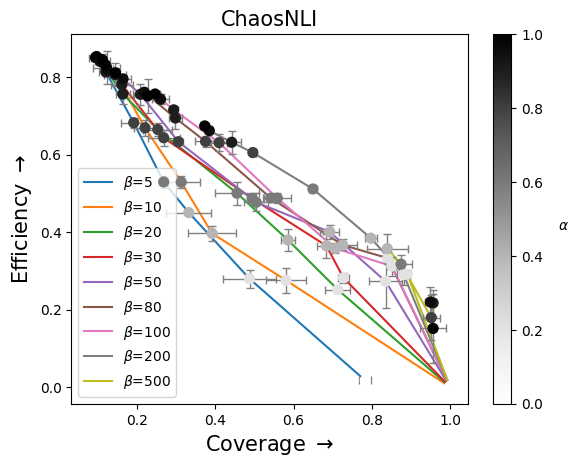

In [15]:
%load_ext autoreload
%autoreload 2
from models import LikelihoodEnsemble, get_model, Ensemble, DesterckeEnsemble, CaprioEnsemble, WangEnsemble
import torch
import numpy as np
from data import get_data_task
import utils
from probly.metrics import coverage, efficiency, coverage_convex_hull
import matplotlib.pyplot as plt
PATH = '/home/scratch/likelihood-ensembles/checkpoints'

data_dict = {'chaosnli': 'ChaosNLI', 'cifar10': 'CIFAR10', 'qualitymri': 'QualityMRI'}
color_dict = {'ours': '#2ca02c', 'credalwrapper': '#2ca02c', 'credalensembling': '#2ca02c', 'credalbnn': '#2ca02c'}
font_size=15
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
dataset = 'chaosnli'
base = 'fcnet'
seeds = [4, 5, 6]
n_members = 20
classes = 3
plt.plot()
cmap = plt.get_cmap('tab10')
n = 10
colors = [cmap(i / (n - 1)) for i in range(n)]
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
tobiass = [5,10,20,30,50,80,100,200,500]
for tobias in tobiass:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))
    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    plt.plot(covs.mean(0), effs.mean(0), label=rf'$\beta$={tobias}')
    plt.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=50, zorder=10, vmin=0, vmax=1)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        plt.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=5)

cb = plt.colorbar(orientation='vertical')
cb.set_label('$\\alpha$', rotation=0, labelpad=15,weight='bold')
plt.legend()
plt.xlabel('Coverage '+  r"$\rightarrow$", fontsize=font_size)
plt.ylabel('Efficiency '+  r"$\rightarrow$", fontsize=font_size)
plt.title(f'{data_dict[dataset]}', fontsize=font_size)
plt.show()

## Ablation: effect of members

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:00<00:00, 25.96it/s]


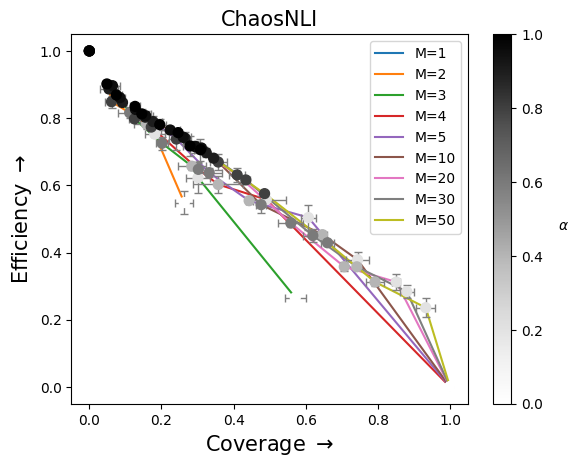

In [16]:
%load_ext autoreload
%autoreload 2
from models import LikelihoodEnsemble, get_model, Ensemble, DesterckeEnsemble, CaprioEnsemble, WangEnsemble
import torch
import numpy as np
from data import get_data_task
import utils
from probly.metrics import coverage, efficiency, coverage_convex_hull
import matplotlib.pyplot as plt
PATH = '/home/scratch/likelihood-ensembles/checkpoints'

data_dict = {'chaosnli': 'ChaosNLI', 'cifar10': 'CIFAR10', 'qualitymri': 'QualityMRI'}
color_dict = {'ours': '#2ca02c', 'credalwrapper': '#2ca02c', 'credalensembling': '#2ca02c', 'credalbnn': '#2ca02c'}
font_size=15
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
dataset = 'chaosnli'
base = 'fcnet'
seeds = [4, 5, 6]
classes = 3
plt.plot()
cmap = plt.get_cmap('tab10')
tobias = 100
n = 10
colors = [cmap(i / (n - 1)) for i in range(n)]
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
members = [1, 2, 3, 4, 5, 10, 20, 30, 50]
for n_members in members:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))
    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    plt.plot(covs.mean(0), effs.mean(0), label=f'M={n_members}')
    plt.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=50, zorder=10, vmin=0, vmax=1)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        plt.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=5)


cb = plt.colorbar(orientation='vertical')
cb.set_label('$\\alpha$', rotation=0, labelpad=15,weight='bold')
plt.legend()
plt.xlabel('Coverage '+  r"$\rightarrow$", fontsize=font_size)
plt.ylabel('Efficiency '+  r"$\rightarrow$", fontsize=font_size)
plt.title(f'{data_dict[dataset]}',fontsize=font_size)
plt.show()

## Full plot members

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:00<00:00, 32.45it/s]


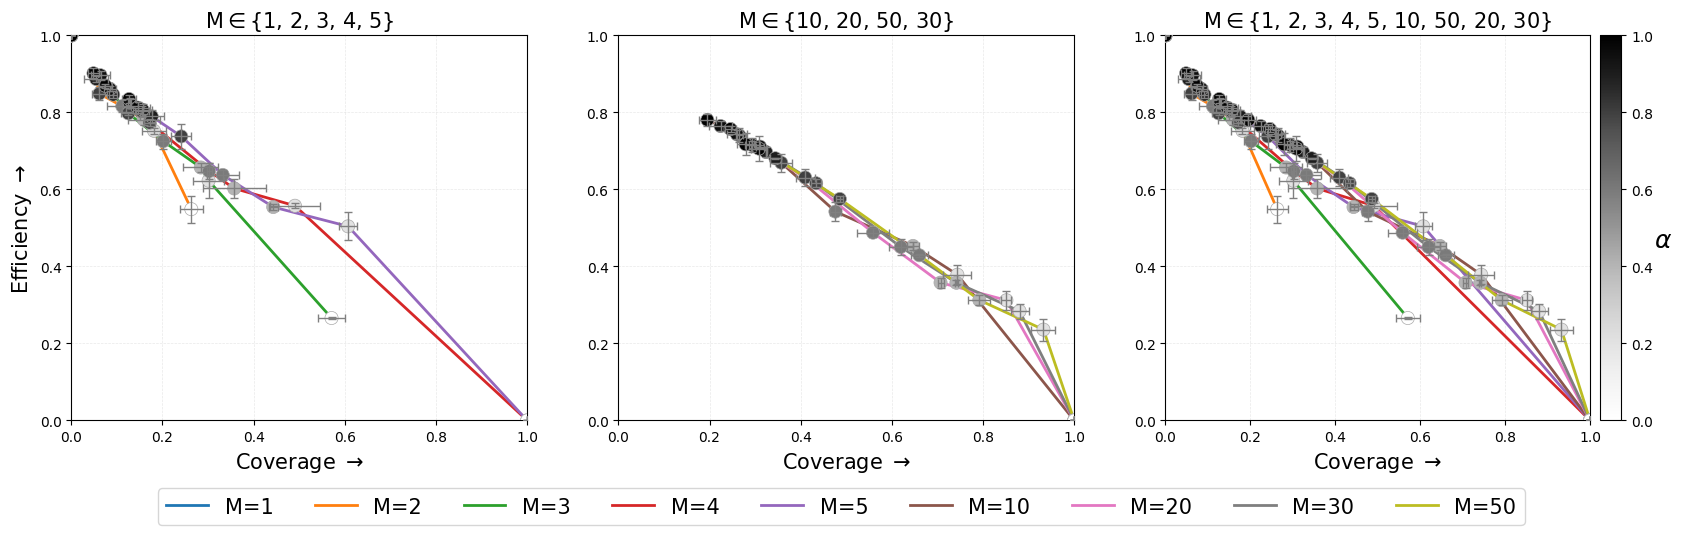

In [17]:
%load_ext autoreload
%autoreload 2
from models import LikelihoodEnsemble, get_model, Ensemble, DesterckeEnsemble, CaprioEnsemble, WangEnsemble
import torch
import numpy as np
from data import get_data_task
import utils
from probly.metrics import coverage, efficiency, coverage_convex_hull
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
PATH = '/home/scratch/likelihood-ensembles/checkpoints'

data_dict = {'chaosnli': 'ChaosNLI', 'cifar10': 'CIFAR10', 'qualitymri': 'QualityMRI'}
color_dict = {'ours': '#2ca02c', 'credalwrapper': '#2ca02c', 'credalensembling': '#2ca02c', 'credalbnn': '#2ca02c'}
font_size=15
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
dataset = 'chaosnli'
base = 'fcnet'
seeds = [4, 5, 6]
# seeds = [4, 5]
classes = 3


edgecolor = 'darkgrey'
s=90
line_width=2
font_size=15

tobias = 100
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
members = [1, 2, 3, 4, 5, 10, 20, 30, 50]
cmap = plt.get_cmap('tab10')

color_dict = {m: cmap(i % 10) for i, m in enumerate(members)}


fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = axes[0]
ax.set_xticks(np.linspace(0.0, 1.0, 6))
ax.set_xlim(0.0, 1.0)
ax.set_yticks(np.linspace(0.0, 1.0, 6))
ax.set_ylim(0.0, 1.0)
ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
ax.tick_params(axis='both', colors='black')
members0 = members[:5]
for n_members in members0:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))

    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    ax.plot(covs.mean(0), effs.mean(0), color=color_dict[n_members], linewidth=line_width)
    ax.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=s, zorder=10, vmin=0, vmax=1, edgecolors=edgecolor, linewidths=0.5)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

ax.set_title(rf'M$\in${set(members0)}', fontsize=font_size)
ax.set_xlabel('Coverage ' + r"$\rightarrow$", fontsize=font_size)
ax.set_ylabel('Efficiency '+  r"$\rightarrow$", fontsize=font_size)

ax = axes[1]
ax.set_xticks(np.linspace(0.0, 1.0, 6))
ax.set_xlim(0.0, 1.0)
ax.set_yticks(np.linspace(0.0, 1.0, 6))
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='both', colors='black')
ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
members1 = members[5:]
for n_members in members1:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))
    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    ax.plot(covs.mean(0), effs.mean(0), color=color_dict[n_members], linewidth=line_width)
    ax.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=s, zorder=10, vmin=0, vmax=1, edgecolors=edgecolor, linewidths=0.5)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

ax.set_title(rf'M$\in${set(members1)}', fontsize=font_size)
ax.set_xlabel('Coverage ' + r"$\rightarrow$", fontsize=font_size)

ax = axes[2]
ax.set_xticks(np.linspace(0.0, 1.0, 6))
ax.set_xlim(0.0, 1.0)
ax.set_yticks(np.linspace(0.0, 1.0, 6))
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='both', colors='black')
ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
for n_members in members:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))
    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    ax.plot(covs.mean(0), effs.mean(0), label=f'M={n_members}', color=color_dict[n_members], linewidth=line_width)
    map = ax.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=s, zorder=10, vmin=0, vmax=1, edgecolors=edgecolor, linewidths=0.5)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

ax.set_title(rf'M$\in${set(members)}', fontsize=font_size)
ax.set_xlabel('Coverage ' + r"$\rightarrow$", fontsize=font_size)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(map, cax=cax)
cb.set_label('$\\alpha$', rotation=0, labelpad=7, fontsize=font_size+3 ,weight='bold')

legend = fig.legend(loc='lower center', ncol=9, frameon=True,
           bbox_to_anchor=(0.51, -0.12), fontsize=font_size, bbox_transform=fig.transFigure)
# plt.subplots_adjust(bottom=0.3) # Leave space for colorbar
# plt.savefig('/home/ra79jox/likelihood-ensembles/plots/ablation_members.pdf', bbox_inches='tight')
plt.show()

## Full plot tobias

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:00<00:00, 29.09it/s]


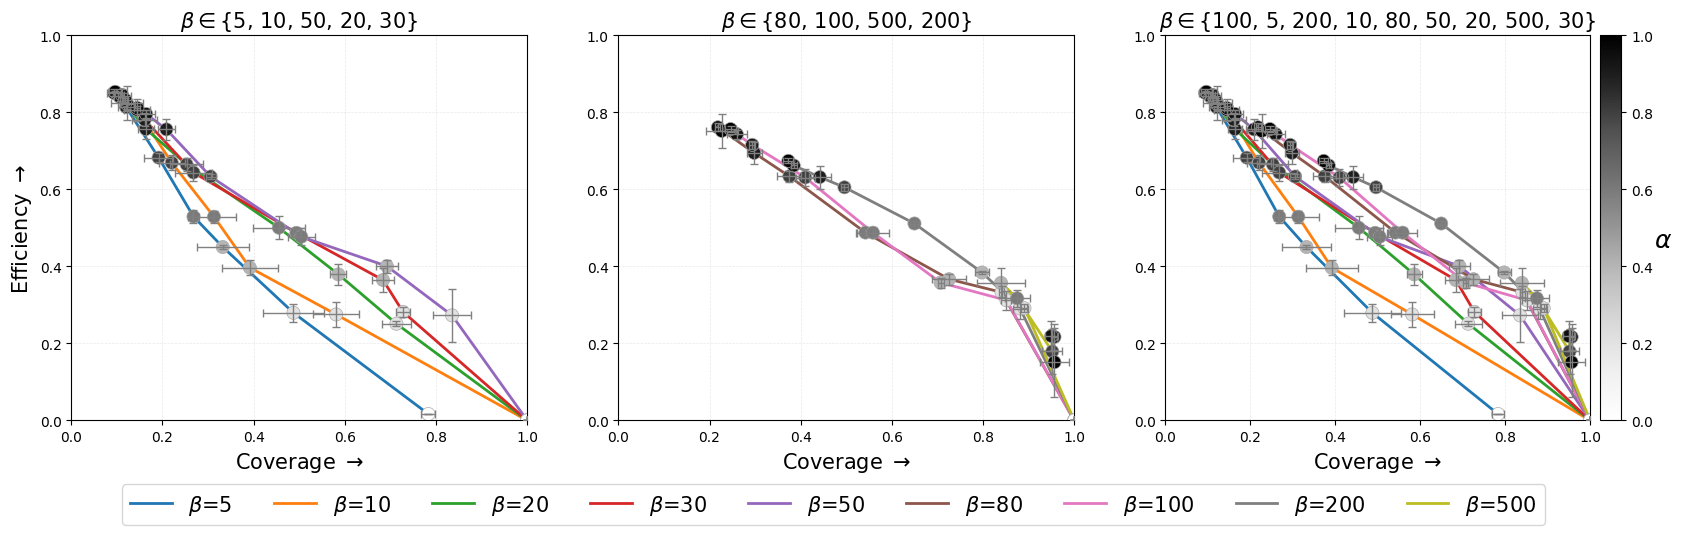

In [18]:
%load_ext autoreload
%autoreload 2
from models import LikelihoodEnsemble, get_model
import torch
from data import get_data_task
import utils
from probly.metrics import coverage, efficiency
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
PATH = '/home/scratch/likelihood-ensembles/checkpoints'

data_dict = {'chaosnli': 'ChaosNLI', 'cifar10': 'CIFAR10', 'qualitymri': 'QualityMRI'}
color_dict = {'ours': '#2ca02c', 'credalwrapper': '#2ca02c', 'credalensembling': '#2ca02c', 'credalbnn': '#2ca02c'}
font_size=15
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
dataset = 'chaosnli'
base = 'fcnet'
seeds = [4, 5, 6]
# seeds = [4, 5]
classes = 3


edgecolor = 'darkgrey'
s=90
line_width=2
font_size=15


tobiass = [5,10,20,30,50,80,100,200,500]

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0]
n_members = 20
cmap = plt.get_cmap('tab10')

color_dict = {t: cmap(i % 10) for i, t in enumerate(tobiass)}


fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = axes[0]
ax.set_xticks(np.linspace(0.0, 1.0, 6))
ax.set_xlim(0.0, 1.0)
ax.set_yticks(np.linspace(0.0, 1.0, 6))
ax.set_ylim(0.0, 1.0)

ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
ax.tick_params(axis='both', colors='black')
tobiass0 = tobiass[:5]
for tobias in tobiass0:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))
    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    ax.plot(covs.mean(0), effs.mean(0), color=color_dict[tobias], linewidth=line_width)
    ax.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=s, zorder=10, vmin=0, vmax=1, edgecolors=edgecolor, linewidths=0.5)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

ax.set_title(rf'$\beta\in${set(tobiass0)}', fontsize=font_size)
ax.set_xlabel('Coverage ' + r"$\rightarrow$", fontsize=font_size)
ax.set_ylabel('Efficiency '+  r"$\rightarrow$", fontsize=font_size)

ax = axes[1]
ax.set_xticks(np.linspace(0.0, 1.0, 6))
ax.set_xlim(0.0, 1.0)
ax.set_yticks(np.linspace(0.0, 1.0, 6))
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='both', colors='black')
ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
tobiass1 = tobiass[5:]
for tobias in tobiass1:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))
    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    ax.plot(covs.mean(0), effs.mean(0), color=color_dict[tobias], linewidth=line_width)
    ax.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=s, zorder=10, vmin=0, vmax=1, edgecolors=edgecolor, linewidths=0.5)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

ax.set_title(rf'$\beta\in${set(tobiass1)}', fontsize=font_size)
ax.set_xlabel('Coverage ' + r"$\rightarrow$", fontsize=font_size)

ax = axes[2]
ax.set_xticks(np.linspace(0.0, 1.0, 6))
ax.set_xlim(0.0, 1.0)
ax.set_yticks(np.linspace(0.0, 1.0, 6))
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='both', colors='black')
ax.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, alpha=0.5)
for tobias in tobiass:
    covs = np.empty((len(seeds), len(alphas)))
    effs = np.empty((len(seeds), len(alphas)))
    for j, seed in enumerate(seeds):
        test_loader = get_data_task(dataset, seed=seed)
        for i, alpha in enumerate(alphas):
            ensemble = LikelihoodEnsemble(get_model(base, classes), classes, n_members=n_members, tobias_value=tobias)
            utils.load_ensemble(ensemble, f'{PATH}/{dataset}_{base}_{n_members}_{tobias}_{alpha}_{seed}')
            ensemble = ensemble.to(device)
            ensemble.eval()
            outputs, targets = utils.torch_get_outputs(ensemble, test_loader, device)
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            cov = coverage(outputs, targets)
            eff = efficiency(outputs)
            covs[j, i] = cov
            effs[j, i] = eff
    ax.plot(covs.mean(0), effs.mean(0), label=rf'$\beta$={tobias}', color=color_dict[tobias], linewidth=line_width)
    map = ax.scatter(covs.mean(0), effs.mean(0), cmap='Greys', c=alphas, marker='o', s=s, zorder=10, vmin=0, vmax=1, edgecolors=edgecolor, linewidths=0.5)

    for x, y, xe, ye in zip(covs.mean(0), effs.mean(0), covs.std(0), effs.std(0)):
        ax.errorbar(x, y, xerr=xe, yerr=ye, fmt='none', ecolor='gray', elinewidth=1, capsize=3, zorder=25)

ax.set_title(rf'$\beta\in${set(tobiass)}', fontsize=font_size)
ax.set_xlabel('Coverage ' + r"$\rightarrow$", fontsize=font_size)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(map, cax=cax)
cb.set_label('$\\alpha$', rotation=0, labelpad=7, fontsize=font_size+3 ,weight='bold')

legend = fig.legend(loc='lower center', ncol=9, frameon=True,
           bbox_to_anchor=(0.506, -0.12), fontsize=font_size, bbox_transform=fig.transFigure)
# plt.savefig('/home/ra79jox/likelihood-ensembles/plots/ablation_tobias.pdf', bbox_inches='tight')
plt.show()